# Motivation
- What is your dataset?

- Why did you choose this/these particular dataset(s)?

- What was your goal for the end user's experience?

We chose to investigate traffic collissions in the New York City area. Our motivation for looking into this data set is to determine the changes of traffic collission in correlation drunk driving in New York City throughout the past years. The goal is to create a prediction of how it is expected to develop over the comming years, whilst highlighting collussion hotspots for this specific trend, allowing public safety to act on these to decrease drunk driving collissions in hotspots.


# Basic stats. Let's understand the dataset better
- Write about your choices in data cleaning and preprocessing

- Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

In [1]:
%matplotlib inline

from csv import reader
import urllib2
from collections import Counter, defaultdict
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
import collections


import matplotlib.pylab as plt
import geoplotlib
from geoplotlib.utils import BoundingBox, DataAccessObject
import plotly.plotly as py

date = []
time = []
borough = []
zipCode = []
lat = []
lon = []
locaiton = []
onStreetName = []
crossStreetName = []
offStreetName = []
personInjured = []
personsKilled = []
pedestriansInjured = []
pedestrainsKilled = []
cyclistInjured = []
cyclistKilled = []
motoristInjured = []
motoristKilled = []
contriFactorVehicle1 = []
contriFactorVehicle2 = []
contriFactorVehicle3 = []
contriFactorVehicle4 = []
contriFactorVehicle5 = []
uniqueKey = []
vehicleTypeCode1 = []
vehicleTypeCode2 = []
vehicleTypeCode3 = []
vehicleTypeCode4 = []
vehicleTypeCode5 = []

data = open("NYPD_Motor_Vehicle_Collisions.csv")
variables = next(data,1).split(',')

countRows=0
for line in reader(data): 
    var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29 = line
    
    date.append(var1)
    time.append(var2)
    borough.append(var3)
    zipCode.append(var4)
    try:
        lat.append(float(var5))
    except:
        lat.append(float(0.0))
    try:
        lon.append(float(var6))
    except:
        lon.append(float(0.0))
    locaiton.append(var7)
    onStreetName.append(var8)
    crossStreetName.append(var9)
    offStreetName.append(var10)
    personInjured.append(var11)
    personsKilled.append(var12)
    pedestriansInjured.append(var13)
    pedestrainsKilled.append(var14)
    cyclistInjured.append(var15)
    cyclistKilled.append(var16)
    motoristInjured.append(var17)
    motoristKilled.append(var18)
    contriFactorVehicle1.append(var19)
    contriFactorVehicle2.append(var20)
    contriFactorVehicle3.append(var21)
    contriFactorVehicle4.append(var22)
    contriFactorVehicle5.append(var23)
    uniqueKey.append(var24)
    vehicleTypeCode1.append(var25)
    vehicleTypeCode2.append(var26)
    vehicleTypeCode3.append(var27)
    vehicleTypeCode4.append(var28)
    vehicleTypeCode5.append(var29)
    countRows +=1
print countRows

769054


The first thing we did was to append all of our data into corrosponding arrays for easy access. From here we started investigating the different variables in the dataset.

In [2]:
borough_set=set(borough)
print borough_set, '\n'

borough_counter=Counter(borough)
print borough_counter, "\n"

unspecified_borough =borough_counter
print 'Unspecified borough data points',unspecified_borough['']

set(['', 'STATEN ISLAND', 'BROOKLYN', 'BRONX', 'MANHATTAN', 'QUEENS']) 

Counter({'': 184301, 'BROOKLYN': 178741, 'MANHATTAN': 153824, 'QUEENS': 150226, 'BRONX': 74465, 'STATEN ISLAND': 27497}) 

Unspecified borough data points 184301


Early on we found our first red alarm, when we looked into the borough of the dataset. Here we found that five areas were specified (Brooklyn, Manhattan, Queens, Bronx, Staten Island), whilst a last one were an empty string that occoured 184301 times. 

In [3]:
percentageOfData = float(unspecified_borough[''])/float(countRows)*100
print "The data set consist of" ,percentageOfData,"% unspecified borough data points. Based on this we considered removing the data from the dataset to be out of the question, since it would have a significant impact on the end results."

The data set consist of 23.9646370736 % unspecified borough data points. Based on this we considered removing the data from the dataset to be out of the question, since it would have a significant impact on the end results.


Based on this we started to investigate further into the data set to figure out the optimal solution in relation filling out this missing data. Our train of thought quickly led to using latitude and longtitude information to fill out missing borough data. In order to do so, we had to figure out if the missing borough information despite all odds contained longtitude and latitude information.

Before we looked into this, we wanted to know if there was any missing longtitude and latitude data. 

In [4]:
latCount =0
lonCount = 0

for la in lat:
    if la ==0.0:
        latCount+=1
for lo in lon:
    if lo ==0.0:
        lonCount+=1
    
print 'There are',latCount, 'data points that does not have latitude'
print 'There are',lonCount, 'data points that does not have  longtitude'

There are 121187 data points that does not have latitude
There are 121187 data points that does not have  longtitude


- NOTIFICATION: The value 0.0 = missing data points. We chose to insert 0.0 as float in variable initialization for longtitude and latitude data points that did not excist in the dataset. The value 0.0 was chosen to make it easy to filter out when doing geomapping.


We found that 121187 data points within the longtitude and latitude data was in fact missing.

In [5]:
lonlatContained = (184301-121187)/float(countRows)*100
print lonlatContained, '% of the missing borough data might be savable, since it does contain longtitude and latitude'
print percentageOfData-lonlatContained, '% will have to be ignore in terms of geo data.'

8.20670590102 % of the missing borough data might be savable, since it does contain longtitude and latitude
15.7579311726 % will have to be ignore in terms of geo data.


A quick calculation of percentage showed us that we might be able to fill out 8.2% of the total missing borough data (total of whole data set) out of the total 23.9% missing. In order to say for sure we needed to find out whether the data points missing longtitude and latitude were in fact the same as he once missing borough.

In [6]:
lostData=0

for la,lo,bo in zip(lat,lon,borough):
    if (la==0.0 and lo==0.0 and bo==""):
        lostData+=1
print 'There are',lostData,'data points that does not have latitude, longtitude and borough.'

There are 121184 data points that does not have latitude, longtitude and borough.


- 121184 of 121187 data points miss latitude, longtitude and borough: the difference of 3 is not fillable since its longtitude and latitude info missing.

As expected most of the data that missed latitude and longtitude also missed borough, but not vice versa. In other words, this means that we are in fact able to fill out 8.2% of the missing borough data (of the whole data set) by using latitude and longtitude to determine the borough.


It should be mentioned that we do not intend to delete the remaing 15.7% that we are not able to fill out. Instead we are going to use this data for overall calculations, such as number of accidents etc. to form stronger predictions, whilst we will be forced to ignore/neglect these 15.7% when plotting geomapping. (ignore: this will be done by using the inserted 0.0 float value as filter.)

The next step from here is to fill out the 8.2% borough data that we are able to save. This will be done by using longtitude and latitude for those data points and then determining 6 of the K-nearest neighbors and take mode (value that appears most often) of their borough in order to determine the most probable correct borough.

In [7]:
#import math, operator
#from collections import Counter

#tuples=[]
#missingBorough1=[]
#missingBorough2=[]
#missingBorough3=[]
#missingBorough4=[]
#missingBorough5=[]
#missingBorough6=[]
#input_indexCounter=0
#input_index=[]
#breakout1=0
#breakout2=0
#breakout3=0
#breakout4=0
#breakout5=0
#breakout6=0
#startprint =0
#class KNNSolver(object):

#    def __init__(self, points):
#        self.points = points

#    def closest_to(self, point, k=1):
#        nearest = dict()

#        for p in self.points:
#            if (p == point): continue
#            dist = self._dist(p, point)
#            nearest.setdefault(p, dist)

#        sorted_points = sorted(nearest.items(), key=operator.itemgetter(1))
#        return [p for p, dist in sorted_points][0:k]

#    def _dist(self, a, b):
#        x1, x2 = a[0], b[0]
#        y1, y2 = a[1], b[1]
#        return math.sqrt(math.pow(x2 - x1, 2) + math.pow(y2 - y1, 2))

#for la,lo in zip(lat,lon):
#    tuples.append(tuple([la,lo]))

#for bo,la,lo in zip(borough,lat, lon):
#    input_indexCounter+=1
#    if (bo == "" and la !=0.0 and lon !=0.0):
#        if (la !=0.0 and lon !=0.0):
#            input_index.append(input_indexCounter)
#            input_point = (la,lo)
#            solver = KNNSolver(tuples)
#            closest_points = solver.closest_to(input_point, 3)
#            for n in range(len(lat)):
#                if (closest_points[0:1]==tuples[n:n+1] and borough[n]!=''):
#                    missingBorough1.append(borough[n])
#                    breakout1+=1
#            for i in range(len(lat)):
#                 if (closest_points[1:2]==tuples[i:i+1] and borough[i]!=''):
#                    missingBorough2.append(borough[i])
#                    breakout2+=1
#            for s in range(len(lat)):
#                 if (closest_points[2:3]==tuples[s:s+1] and borough[s]!=''):
#                    missingBorough3.append(borough[s])
#                    breakout3+=1
#            for t in range(len(lat)):
#                 if (closest_points[3:4]==tuples[t:t+1] and borough[t]!=''):
#                    missingBorough4.append(borough[t])
#                    breakout4+=1
#            for z in range(len(lat)):
#                 if (closest_points[4:5]==tuples[z:z+1] and borough[z]!=''):
#                    missingBorough5.append(borough[z])
#                    breakout5+=1
#            for o in range(len(lat)):
#                 if (closest_points[5:6]==tuples[o:o+1] and borough[o]!=''):
#                    missingBorough6.append(borough[o])
#                    breakout6+=1
                    
#            if(breakout1==63114 and breakout2==63114 and breakout3==63114 and breakout4==63114 and breakout5==63114 and breakout6==63114):
#                startprint=1
                    
#while (startprint==1):
#    for i in range (len(input_index)):
#        data = Counter(missingBorough1[i],missingBorough2[i],missingBorough3[i],missingBorough4[i],missingBorough5[i],missingBorough6[i])
#        borough[input_index[i]]=data.most_common(1)
        

#    startprint=2

The out-commented code above does exactly as explained and fills out the missing borough data (8.2%). Anyhow we have to exclude this super awesome functionaility that fills out the data, since it proved itself to be way to processing heavy. We estimated the calculation time to be around 18hours+ to fill out the missing data due to the processing limitation of jupyter notebook. Based on this we were sadly forced to exclude this solution of filling out data and just remove the data (23.9% ).

The code below is therefor a re-implementation of the dataset, where we delimit it to contain only the following criteria:
- No missing BOROUGH data.
- No missing DATE data.
- No missing Time data.
- No missing LATITUDE data.
- No missing LONGTITUDE data.

In [8]:
%matplotlib inline
import csv
from csv import reader
import urllib2
from collections import Counter, defaultdict
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
import collections
import pandas as pd
import matplotlib.pylab as plt
import geoplotlib
from geoplotlib.utils import BoundingBox, DataAccessObject
import plotly.plotly as py


input_data=pd.read_csv("NYPD_Motor_Vehicle_Collisions.csv")

new_data=input_data.drop(['ZIP CODE', 'UNIQUE KEY','ON STREET NAME', 'OFF STREET NAME', 'CROSS STREET NAME'],axis=1)
newer_data=new_data.dropna(subset=['BOROUGH','LATITUDE','LONGITUDE','DATE','TIME'])
data=newer_data.reset_index(drop=True)

print data.keys(), '\n'
print data.shape

Index([u'DATE', u'TIME', u'BOROUGH', u'LATITUDE', u'LONGITUDE', u'LOCATION',
       u'NUMBER OF PERSONS INJURED', u'NUMBER OF PERSONS KILLED',
       u'NUMBER OF PEDESTRIANS INJURED', u'NUMBER OF PEDESTRIANS KILLED',
       u'NUMBER OF CYCLIST INJURED', u'NUMBER OF CYCLIST KILLED',
       u'NUMBER OF MOTORIST INJURED', u'NUMBER OF MOTORIST KILLED',
       u'CONTRIBUTING FACTOR VEHICLE 1', u'CONTRIBUTING FACTOR VEHICLE 2',
       u'CONTRIBUTING FACTOR VEHICLE 3', u'CONTRIBUTING FACTOR VEHICLE 4',
       u'CONTRIBUTING FACTOR VEHICLE 5', u'VEHICLE TYPE CODE 1',
       u'VEHICLE TYPE CODE 2', u'VEHICLE TYPE CODE 3', u'VEHICLE TYPE CODE 4',
       u'VEHICLE TYPE CODE 5'],
      dtype='object') 

(584750, 24)


Additionally the printed values above are the keys used to access the different data values and the shape of the dataset (584750 rows and 24 columns). The code below shows the dataframe.

In [9]:
data.iloc[:]

,DATE,TIME,BOROUGH,LATITUDE,LONGITUDE,LOCATION,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,03/07/2016,10:40,BROOKLYN,40.680168,-73.876573,"(40.6801678, -73.8765734)",1,0,0,0,...,Fatigued/Drowsy,Unspecified,Unspecified,NaN,NaN,TAXI,PASSENGER VEHICLE,TAXI,NaN,NaN
1,03/12/2016,15:10,BROOKLYN,40.602422,-73.994584,"(40.6024219, -73.9945838)",0,0,0,0,...,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
2,03/03/2016,18:45,BRONX,40.818750,-73.890378,"(40.8187504, -73.8903777)",0,0,0,0,...,Unspecified,Unspecified,NaN,NaN,NaN,PASSENGER VEHICLE,UNKNOWN,NaN,NaN,NaN
3,03/12/2016,15:20,QUEENS,40.677886,-73.745609,"(40.6778859, -73.7456092)",1,0,0,0,...,Unspecified,Unspecified,NaN,NaN,NaN,MOTORCYCLE,PASSENGER VEHICLE,NaN,NaN,NaN
4,03/13/2016,19:10,MANHATTAN,40.740262,-73.990516,"(40.7402615, -73.9905165)",0,0,0,0,...,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,LIVERY VEHICLE,TAXI,NaN,NaN,NaN
5,03/12/2016,15:24,MANHATTAN,40.774655,-73.954093,"(40.7746554, -73.9540926)",0,0,0,0,...,Other Vehicular,Driver Inexperience,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,TAXI,NaN,NaN,NaN
6,03/13/2016,20:00,BROOKLYN,40.621719,-73.921360,"(40.6217185, -73.9213599)",0,0,0,0,...,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
7,03/07/2016,13:00,BROOKLYN,40.679296,-73.906424,"(40.6792956, -73.9064236)",0,0,0,0,...,Unspecified,Unspecified,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN
8,03/12/2016,15:25,MANHATTAN,40.748356,-74.003688,"(40.7483561, -74.0036885)",0,0,0,0,...,Fatigued/Drowsy,Fatigued/Drowsy,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
9,03/12/2016,15:27,BRONX,40.833558,-73.857732,"(40.8335582, -73.8577325)",4,0,0,0,...,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,VAN,PASSENGER VEHICLE,NaN,NaN,NaN


In [10]:
type(data.describe())
print data


              DATE   TIME        BOROUGH   LATITUDE  LONGITUDE  \
0       03/07/2016  10:40       BROOKLYN  40.680168 -73.876573   
1       03/12/2016  15:10       BROOKLYN  40.602422 -73.994584   
2       03/03/2016  18:45          BRONX  40.818750 -73.890378   
3       03/12/2016  15:20         QUEENS  40.677886 -73.745609   
4       03/13/2016  19:10      MANHATTAN  40.740262 -73.990516   
5       03/12/2016  15:24      MANHATTAN  40.774655 -73.954093   
6       03/13/2016  20:00       BROOKLYN  40.621719 -73.921360   
7       03/07/2016  13:00       BROOKLYN  40.679296 -73.906424   
8       03/12/2016  15:25      MANHATTAN  40.748356 -74.003688   
9       03/12/2016  15:27          BRONX  40.833558 -73.857732   
10      03/03/2016  18:55       BROOKLYN  40.619381 -73.982883   
11      03/12/2016  15:30       BROOKLYN  40.688563 -73.875707   
12      03/12/2016  15:30         QUEENS  40.710102 -73.753357   
13      03/12/2016  15:35       BROOKLYN  40.690666 -73.985364   
14      03

The code barchart below shows the overall number of collisions based on each year.

Counter({'2015': 163363, '2014': 156277, '2013': 155948, '2012': 77560, '2016': 31602})


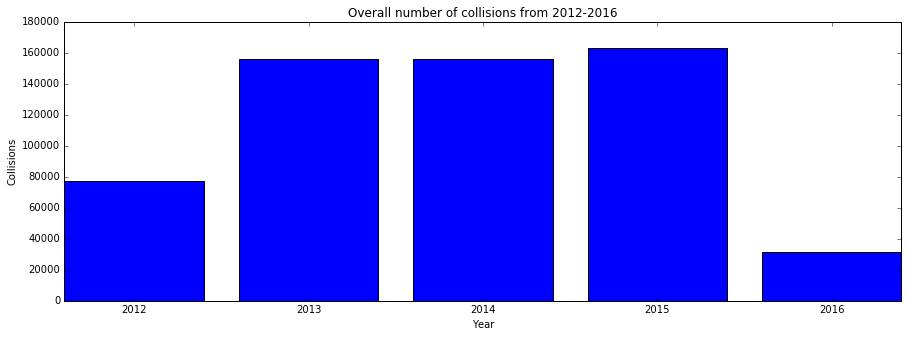

In [34]:
year_set=[]
for i in range(len(data['DATE'])):
    if (data['DATE'][i][6:] == '2012'):
        year_set.append(data['DATE'][i][6:])
    if (data['DATE'][i][6:] == '2013'):
        year_set.append(data['DATE'][i][6:])
    if (data['DATE'][i][6:] == '2014'):
        year_set.append(data['DATE'][i][6:])
    if (data['DATE'][i][6:] == '2015'):
        year_set.append(data['DATE'][i][6:])
    if (data['DATE'][i][6:] == '2016'):
        year_set.append(data['DATE'][i][6:])
year_set= Counter(year_set)
print year_set

plt.figure(figsize=(15,5))
x_axis = ['2012','2013','2014','2015','2016']
y_axis = [year_set['2012'],year_set['2013'],year_set['2014'],year_set['2015'],year_set['2016']]
ind = np.arange(len(x_axis))
plt.title('Overall number of collisions from 2012-2016')
plt.ylabel('Collisions')
plt.xlabel('Year')
plt.xticks(ind+0.4,x_axis)
plt.bar(ind,y_axis)
plt.show()

The most prominent factor when looking at the barchart above is the 2012 and 2016, since they are significantly lower than the others. We looked into this and found that this is because 2012 and 2016 is not a full year and therefore the data is unrealiable in year perspective. Anyhow with that said it is prominent that the number of accidents has increased from 2013 to 2015.

The code below creates a barchart showing the overall number of collisions in boroughs over the last four years.

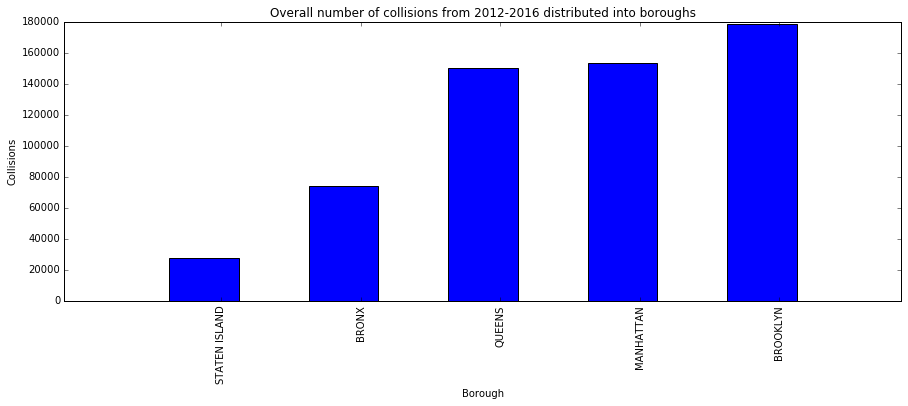

In [25]:
mask = np.zeros_like(data['BOROUGH'],dtype='bool')
borough_set=set(data['BOROUGH'])
for i in range(len(data['BOROUGH'])):
    if data['BOROUGH'][i] in borough_set:
        mask[i] =True


borough_accidents = np.asarray(data['BOROUGH'])[mask].tolist()
borough_acci = [(x,borough_accidents.count(x)) for x in set(data['BOROUGH'])]

plt.figure(figsize=(15,5))
x_pos = range(1,len(borough_acci)+1)
Y = borough_acci 
Y.sort(key = lambda x: x[1])
label = list(zip(*Y)[0])
y_pos = zip(*Y)[1]
plt.title('Overall number of collisions from 2012-2016 distributed into boroughs')
plt.ylabel('Collisions')
plt.xlabel('Borough')
plt.bar([x-0.25 for x in x_pos],y_pos,width=0.5)
plt.xticks([x+0.125 for x in x_pos],label,rotation=90)
plt.show()

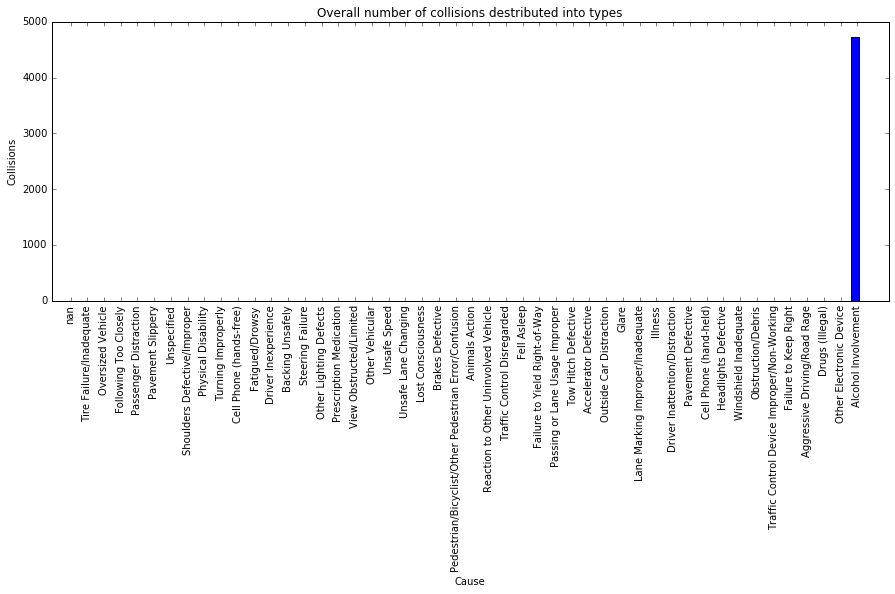

In [35]:
cause_set=set(data['CONTRIBUTING FACTOR VEHICLE 1']),set(data['CONTRIBUTING FACTOR VEHICLE 2']),set(data['CONTRIBUTING FACTOR VEHICLE 3']),set(data['CONTRIBUTING FACTOR VEHICLE 4']),set(data['CONTRIBUTING FACTOR VEHICLE 5'])
for i in range(len(data['CONTRIBUTING FACTOR VEHICLE 1'])):
    if data['CONTRIBUTING FACTOR VEHICLE 1'][i] in cause_set:
        mask[i] =True

cause_accidents = np.asarray(data['CONTRIBUTING FACTOR VEHICLE 1'])[mask].tolist()
cause_acci = [(x,cause_accidents.count(x)) for x in set(data['CONTRIBUTING FACTOR VEHICLE 1'])]

plt.figure(figsize=(15,5))
x_pos = range(1,len(cause_acci)+1)
Y = cause_acci 
Y.sort(key = lambda x: x[1])
label = list(zip(*Y)[0])
y_pos = zip(*Y)[1]
plt.ylabel('Collisions')
plt.xlabel('Cause')
plt.title('Overall number of collisions destributed into types')
plt.bar([x-0.25 for x in x_pos],y_pos,width=0.5)
plt.xticks([x+0.125 for x in x_pos],label,rotation=90)
plt.show()

We choose to investigate drunk driving. Below is a chart that shows the overall number of collissions over the past years affected by alcoholic influence.

Counter({'2014': 1361, '2015': 1348, '2013': 1172, '2012': 565, '2016': 278})


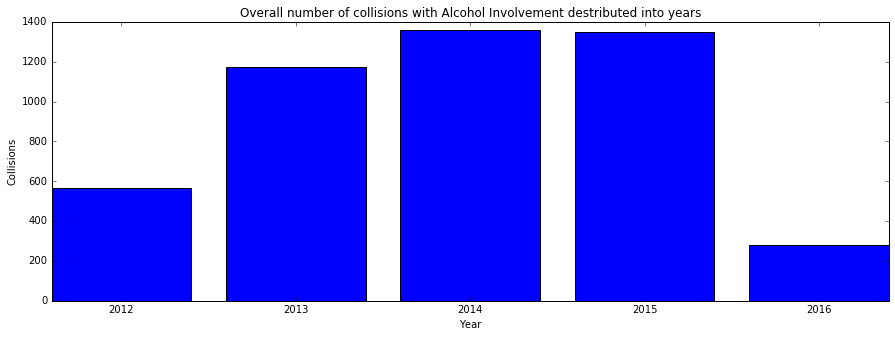

In [19]:
drunkyear_set=[]
for i in range(len(data['DATE'])):
    if (data['DATE'][i][6:] == '2012'and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkyear_set.append(data['DATE'][i][6:])
    if (data['DATE'][i][6:] == '2013'and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkyear_set.append(data['DATE'][i][6:])
    if (data['DATE'][i][6:] == '2014'and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkyear_set.append(data['DATE'][i][6:])
    if (data['DATE'][i][6:] == '2015'and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkyear_set.append(data['DATE'][i][6:])
    if (data['DATE'][i][6:] == '2016'and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkyear_set.append(data['DATE'][i][6:])
        
    
drunkyear_set= Counter(drunkyear_set)
print drunkyear_set

plt.figure(figsize=(15,5))
x_axis = ['2012','2013','2014','2015','2016']
y_axis = [drunkyear_set['2012'],drunkyear_set['2013'],drunkyear_set['2014'],drunkyear_set['2015'],drunkyear_set['2016']]
ind = np.arange(len(x_axis))
plt.title('Overall number of collisions with Alcohol Involvement destributed into years')
plt.ylabel('Collisions')
plt.xlabel('Year')
plt.xticks(ind+0.4,x_axis)
plt.bar(ind,y_axis)
plt.show()

In [27]:
drunkTime_set=[]


for i in range (len(data['CONTRIBUTING FACTOR VEHICLE 1'])):
    if (data['TIME'][i][:2] == '0:' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('0-4')
    if (data['TIME'][i][:2] == '1:' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('0-4')
    if (data['TIME'][i][:2] == '2:' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('0-4')
    if (data['TIME'][i][:2] == '3:' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('0-4')
    if (data['TIME'][i][:2] == '4:' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('4-8')
    if (data['TIME'][i][:2] == '5:' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('4-8')
    if (data['TIME'][i][:2] == '6:' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('4-8')
    if (data['TIME'][i][:2] == '7:' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('4-8')
    if (data['TIME'][i][:2] == '8:' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('8-12')
    if (data['TIME'][i][:2] == '9:' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('8-12')
    if (data['TIME'][i][:2] == '10' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('8-12')
    if (data['TIME'][i][:2] == '11' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('8-12')
    if (data['TIME'][i][:2] == '12' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('12-16')
    if (data['TIME'][i][:2] == '13' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('12-16')
    if (data['TIME'][i][:2] == '14' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('12-16')
    if (data['TIME'][i][:2] == '15' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('12-16')
    if (data['TIME'][i][:2] == '16' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('16-20')
    if (data['TIME'][i][:2] == '17' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('16-20')
    if (data['TIME'][i][:2] == '18' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('16-20')
    if (data['TIME'][i][:2] == '19' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('16-20')
    if (data['TIME'][i][:2] == '20' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('20-24')
    if (data['TIME'][i][:2] == '21' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('20-24')
    if (data['TIME'][i][:2] == '22' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('20-24')
    if (data['TIME'][i][:2] == '23' and data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
        drunkTime_set.append('20-24')
drunkTime_set=Counter(drunkTime_set)
print drunkTime_set

Counter({'0-4': 1379, '4-8': 1031, '20-24': 937, '16-20': 650, '12-16': 366, '8-12': 361})


Counter({'0-4': 1379, '4-8': 1031, '20-24': 937, '16-20': 650, '12-16': 366, '8-12': 361})


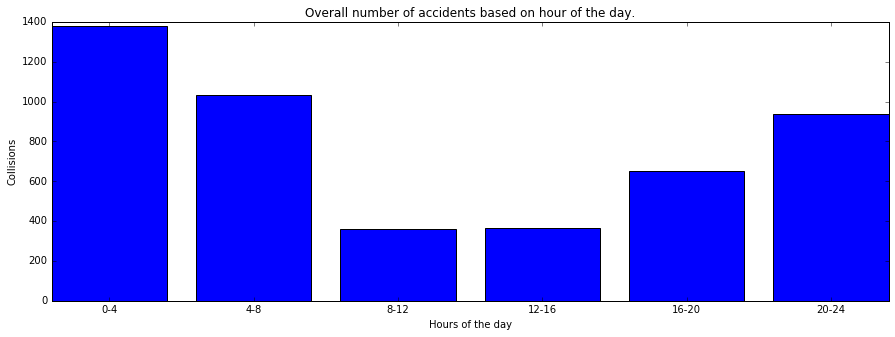

In [28]:
print drunkTime_set
plt.figure(figsize=(15,5))
x_axis = ['0-4','4-8','8-12','12-16','16-20','20-24']
y_axis = [drunkTime_set['0-4'],drunkTime_set['4-8'],drunkTime_set['8-12'],drunkTime_set['12-16'],drunkTime_set['16-20'],drunkTime_set['20-24']]
ind = np.arange(len(x_axis))
plt.title('Overall number of accidents based on hour of the day.')
plt.xlabel('Hours of the day')
plt.ylabel('Collisions')
plt.xticks(ind+0.4,x_axis)
plt.bar(ind,y_axis)
plt.show()

In [33]:
#Bounding box
eps_center = 0.15
max_lat = 40.679515+eps_center
min_lat = 40.679515-eps_center
max_lon = -73.960304+eps_center
min_lon = -73.960304-eps_center
bbox = BoundingBox(north=max_lat, west=min_lon, south=min_lat, east=max_lon)


data['LATITUDE'] = np.asarray(data['LATITUDE']).astype(np.float)
data['LONGITUDE'] = np.asarray(data['LONGITUDE']).astype(np.float)

#creating the mask for data points
mask = np.zeros_like(data['CONTRIBUTING FACTOR VEHICLE 1'],dtype='bool')
for i in range(len(data['LATITUDE'])):
    if (data['LATITUDE'][i]>0.0):
        if(data['CONTRIBUTING FACTOR VEHICLE 1'][i]=='Alcohol Involvement'):
            mask[i] = True
geodata = {'lat': data['LATITUDE'][mask], 'lon': data['LONGITUDE'][mask]}


#Plotting the data
geoplotlib.dot(geodata)
geoplotlib.set_bbox(bbox)
geoplotlib.show()

# Theory. Which theoretical tools did you use?
- Describe which machine learning tools you use and why the tools you've chosen are right for the problem you're solving.

We used KNN for pre-processing to fill out missing borough data. The reason why we chose to use KNN for this is due to the fact that we had most of the latitude and longtitude data for the missing borough data. Therefore we chose to look up the missing borough datas latitude and longtitude and compare it to its k-nearest neighbors. This comparison was done using mode to find the most common answer between the found neighbors and then stored in the missing borough. This was done for each missing borough. Sadly we had to use a limited data set for our actual calculations, since the preprocessing of filling the data was estimated to around 18+ hours due to jupyter notebooks processing power limitations. Therefore we were forced to use a delimited dataset (delete rows with missing: time, date, latitude, longtitude, borough).


- Talk about your model selection. How did you split the data in to test/training. Did you use cross validation?

- Explain the model performance. How did you measure it? Are your results what you expected?

# Visualizations
- Explain the visualizations you've chosen.

- Why are they right for the story you want to tell?

# Discussion. Think critically about your creation
- What went well?,

Importing data went well. Sadly we could not use the KNN fill data we made due to processing powwer limitiation of jupyter notebook. A better red thread through the process could be improved to end up with a stronger and more confident conclusion.

- What is still missing? What could be improved?, Why?

# References
- Make sure that you use references when they're needed and follow academic standards.